In [1]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from __future__ import print_function

## Loading data, training a model

In [3]:
file1 = 'Flight-Level-False-Pos-Data_160920.csv'

df1 = pd.read_csv(file1)
df1 = df1.set_index('p14_event_record')

#df1.head()

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2396 entries, 40509975 to 41000036
Data columns (total 20 columns):
flight_record                                                                2396 non-null int64
flight_date_exact                                                            2396 non-null object
tail_number                                                                  2396 non-null object
airframe                                                                     2396 non-null object
fleet                                                                        2396 non-null object
takeoff_airport_code                                                         2396 non-null object
landing_airport_code                                                         2396 non-null object
p14_event_type                                                               2396 non-null object
p14_severity                                                                 2396 non-null object
p

## dropping columns

In [6]:
df1 = df1.drop(columns = ['flight_record'
                          , 'flight_date_exact'
                          , 'tail_number'
                          , 'airframe'
                          , 'fleet' # this will ne useful in a later version
                          , 'takeoff_airport_code'
                          , 'landing_airport_code'
                          #, 'p14_event_type'
                          , 'p14_false_positive'
                         ])

In [7]:
df1.head()

,p14_severity,p14_start_of_event_10_seconds_seconds_from_start_of_file,p14_end_of_event_10_seconds_seconds_from_start_of_file,p14_data_dropouts_seconds,p14_error_b_w_gmt_and_recorded_time_around_event_percent,p14_estimated_nav_error_at_start_of_event_nm,p14_standard_deviation_of_sample_rate_of_gmt_event_interval_30_seconds_hz,p14_flap_handle_position_at_start_of_event,p14_speed_brake_handle_position_at_start_of_event_deg,p14_flap_position_at_start_of_event_deg_ted,...,event_type_Rotation Speed High,event_type_Rotation Speed Low,event_type_Short Runway Distance Remaining,event_type_Short touchdown,event_type_Speed Brakes Used During Final Approach,event_type_Stick shaker,event_type_TCAS Resolution Advisory,event_type_Thrust reversers delayed during landing,event_type_VFE (Flap Airspeed Limit) Exceedance,event_type_VMO Exceedance
p14_event_record,,,,,,,,,,,,,,,,,,,,,
40509975,Level 2,609.00,629.00,0.0,-0.000095,0.024290,0,5.0,0.641989,5.203770,...,0,0,0,0,0,0,0,0,0,0
40509984,Level 2,5611.25,5637.25,2.0,-0.000436,0.038936,0,30.0,4.200743,30.009817,...,0,0,0,0,0,0,0,0,0,0
40510130,Level 2,688.00,708.00,0.0,-0.000095,0.009928,0,10.0,-1.286268,10.302753,...,0,0,0,0,0,0,0,0,0,0
40510312,Level 2,662.00,682.00,0.0,-0.001526,0.032998,0,1.0,-1.194254,1.030449,...,0,0,0,0,0,0,0,0,0,0
40511060,Level 2,10624.00,10663.00,2.0,-0.001691,0.008319,0,5.0,-1.654518,5.180016,...,0,0,0,0,0,0,1,0,0,0


## label encoding

### one-hot encoding "p_14 event type"

In [5]:
#one hot encoder
df1 = pd.get_dummies(df1, columns=['p14_event_type'], prefix='event_type')
df1.drop(columns='event_type_VMO Exceedance')
#df1

,flight_record,flight_date_exact,tail_number,airframe,fleet,takeoff_airport_code,landing_airport_code,p14_severity,p14_false_positive,p14_start_of_event_10_seconds_seconds_from_start_of_file,...,event_type_Rotation Speed High,event_type_Rotation Speed Low,event_type_Short Runway Distance Remaining,event_type_Short touchdown,event_type_Speed Brakes Used During Final Approach,event_type_Stick shaker,event_type_TCAS Resolution Advisory,event_type_Thrust reversers delayed during landing,event_type_VFE (Flap Airspeed Limit) Exceedance,event_type_VMO Exceedance
p14_event_record,,,,,,,,,,,,,,,,,,,,,
40509975,2869387,25/02/2020 6:13,VH-VXD,737-800,QFA - 737-800 (1024 wps),YPPH,YPAD,Level 2,Not a False Positive,609.00,...,0,0,0,0,0,0,0,0,0,0
40509984,2869366,25/02/2020 7:03,VH-VYF,737-800,QFA - 737-800 (1024 wps),YMML,YSSY,Level 2,Not a False Positive,5611.25,...,0,0,0,0,0,0,0,0,0,0
40510130,2869228,25/02/2020 3:32,VH-XZN,737-800,QFA - 737-800 (1024 wps),YNWN,YPPH,Level 2,Not a False Positive,688.00,...,0,0,0,0,0,0,0,0,0,0
40510312,2869620,25/02/2020 17:05,VH-VZK,737-800,QFA - 737-800 (1024 wps),NZAA,YMML,Level 2,Not a False Positive,662.00,...,0,0,0,0,0,0,0,0,0,0
40511060,2868605,24/02/2020 17:17,VH-XZG,737-800,QFA - 737-800 (1024 wps),NZCH,YSSY,Level 2,Not a False Positive,10624.00,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40998802,2952101,8/09/2020 6:22,VH-XZI,737-800,QFA - 737-800 (1024 wps),YPPH,YGIA,Level 2,Bad Parameter: Bad Sensor on Airplane,6408.00,...,0,0,0,0,1,0,0,0,0,0
40999231,2952678,9/09/2020 22:36,VH-XZM,737-800,QFA - 737-800 (1024 wps),YPPH,YGIA,Level 2,Not a False Positive,524.25,...,0,0,0,0,0,0,0,0,0,0
40999348,2952890,9/09/2020 22:36,VH-XZA,737-800,QFA - 737-800 (1024 wps),YBBN,YPDN,Level 2,Not a False Positive,14890.50,...,0,0,0,0,0,0,0,0,0,0


### mapping p_14 severity levels

In [8]:
df1['p14_severity'] = df1['p14_severity'].map({'Level 2': 0,
                              'Level 3': 1})

## setting features and targets

In [9]:
df1.columns.tolist()

['p14_severity',
 'p14_start_of_event_10_seconds_seconds_from_start_of_file',
 'p14_end_of_event_10_seconds_seconds_from_start_of_file',
 'p14_data_dropouts_seconds',
 'p14_error_b_w_gmt_and_recorded_time_around_event_percent',
 'p14_estimated_nav_error_at_start_of_event_nm',
 'p14_standard_deviation_of_sample_rate_of_gmt_event_interval_30_seconds_hz',
 'p14_flap_handle_position_at_start_of_event',
 'p14_speed_brake_handle_position_at_start_of_event_deg',
 'p14_flap_position_at_start_of_event_deg_ted',
 'target',
 'event_type_Airborne Speed High',
 'event_type_Airspeed Low Relative to Stall Speed',
 'event_type_Altitude Excursion',
 'event_type_Approach Speed High Below 50 ft AGL (Vref)',
 'event_type_Below Minimum Maneuver Speed',
 'event_type_Climb Speed High',
 'event_type_Climb Speed Low',
 'event_type_Deep Touchdown',
 'event_type_Deviation Above GlideSlope 500 to 200 ft AGL',
 'event_type_Deviation Below GlideSlope 500 to 200 ft AGL',
 'event_type_Early Flap Retraction',
 'event_

In [10]:
features = ['p14_severity',
 'p14_start_of_event_10_seconds_seconds_from_start_of_file',
 'p14_end_of_event_10_seconds_seconds_from_start_of_file',
 'p14_data_dropouts_seconds',
 'p14_error_b_w_gmt_and_recorded_time_around_event_percent',
 'p14_estimated_nav_error_at_start_of_event_nm',
 'p14_standard_deviation_of_sample_rate_of_gmt_event_interval_30_seconds_hz',
 'p14_flap_handle_position_at_start_of_event',
 'p14_speed_brake_handle_position_at_start_of_event_deg',
 'p14_flap_position_at_start_of_event_deg_ted',
 'event_type_Airborne Speed High',
 'event_type_Airspeed Low Relative to Stall Speed',
 'event_type_Altitude Excursion',
 'event_type_Approach Speed High Below 50 ft AGL (Vref)',
 'event_type_Below Minimum Maneuver Speed',
 'event_type_Climb Speed High',
 'event_type_Climb Speed Low',
 'event_type_Deep Touchdown',
 'event_type_Deviation Above GlideSlope 500 to 200 ft AGL',
 'event_type_Deviation Below GlideSlope 500 to 200 ft AGL',
 'event_type_Early Flap Retraction',
 'event_type_FLCH  mode below 1000 ft HAT',
 "event_type_GPWS: Don't Sink",
 'event_type_GPWS: Glideslope',
 'event_type_GPWS: Look Ahead Caution',
 'event_type_GPWS: Pull Up',
 'event_type_GPWS: Sink Rate',
 'event_type_GPWS: Terrain',
 'event_type_GPWS: Terrain Pull Up',
 'event_type_GPWS: Too Low Flap',
 'event_type_GPWS: Too Low Gear',
 'event_type_GPWS: Too Low Terrain',
 'event_type_GPWS: Windshear Warning',
 'event_type_High Bank Angle Climb 200ft to 1000 ft',
 'event_type_High Bank Angle Climb below 200 feet',
 'event_type_High Bank Angle Descent Below 200 feet',
 'event_type_High Bank Angle on Flare',
 'event_type_High Rate of Descent 1000 ft HAT -> 500 HAT',
 'event_type_High Speed Below 3000 ft AAL',
 'event_type_High Speed Below 5000 ft AAL',
 'event_type_High Speed Rejected Takeoff',
 'event_type_High Vertical Acceleration at landing',
 'event_type_Idle Thrust Approach',
 'event_type_Landing with incorrect flap',
 'event_type_Late Land Flap Selection',
 'event_type_MMO Exceedance',
 'event_type_Pitch Attitude High During Landing (Gears Compressed)',
 'event_type_Pitch Attitude High During Rotation (Gears Extended)',
 'event_type_Pitch Rate Low during Rotation',
 'event_type_Rotation Speed High',
 'event_type_Rotation Speed Low',
 'event_type_Short Runway Distance Remaining',
 'event_type_Short touchdown',
 'event_type_Speed Brakes Used During Final Approach',
 'event_type_Stick shaker',
 'event_type_TCAS Resolution Advisory',
 'event_type_Thrust reversers delayed during landing',
 'event_type_VFE (Flap Airspeed Limit) Exceedance',
 'event_type_VMO Exceedance']

target = 'target'

In [11]:
X = df1[features]
y = df1[target]

## train test split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## imputing null values

In [13]:
df1.isnull().sum()

p14_severity                                                                 0
p14_start_of_event_10_seconds_seconds_from_start_of_file                     1
p14_end_of_event_10_seconds_seconds_from_start_of_file                       1
p14_data_dropouts_seconds                                                    4
p14_error_b_w_gmt_and_recorded_time_around_event_percent                     1
p14_estimated_nav_error_at_start_of_event_nm                                 1
p14_standard_deviation_of_sample_rate_of_gmt_event_interval_30_seconds_hz    0
p14_flap_handle_position_at_start_of_event                                   1
p14_speed_brake_handle_position_at_start_of_event_deg                        1
p14_flap_position_at_start_of_event_deg_ted                                  1
target                                                                       0
event_type_Airborne Speed High                                               0
event_type_Airspeed Low Relative to Stall Speed     

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X_Scaler = StandardScaler().fit(X_train)
X_Imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(X_train)

In [16]:
#df1.isnull().sum()

## Transform training data

In [17]:
X_train = X_Scaler.transform(X_train)
X_train = X_Imputer.transform(X_train)

## Transform test data

In [18]:
X_test = X_Scaler.transform(X_test)
X_test = X_Imputer.transform(X_test)

## Resampling

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [20]:
X_sm.shape

(2966, 59)

In [21]:
y_sm.shape

(2966,)

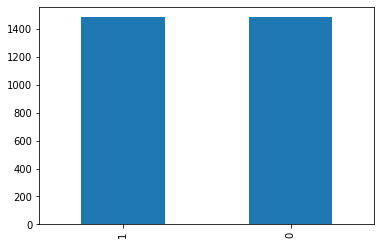

In [22]:
y_sm.value_counts().plot.bar()

## modelling

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [24]:
clf.fit(X_sm, y_sm)

RandomForestClassifier()

In [25]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


## Evaluation

In [26]:
#from sklearn.metrics import accuracy_score
#accuracy_score(y_test, clf.predict(X_test))

In [27]:
actual = y_test

prob_1 = clf.predict_proba(X_test)[:,1]

evaluate = pd.DataFrame({"actual": actual
                        , "prob_1": prob_1
                        })
threshold = 0.5

evaluate["predictions"] = (evaluate["prob_1"] > threshold) *1

print((evaluate["actual"]==evaluate["predictions"]).mean())
evaluate

0.9791376912378303


,actual,prob_1,predictions
p14_event_record,,,
40574590,0,0.00,0
40538350,0,0.00,0
40752318,0,0.00,0
40810629,0,0.14,0
40777536,0,0.05,0
...,...,...,...
40522896,0,0.00,0
40926733,0,0.00,0
40516703,0,0.00,0


In [28]:
#evaluate.head()

In [29]:
evaluate.to_csv('evaluation.csv', index = True, header=True)

### probability/ distribution plot

[]

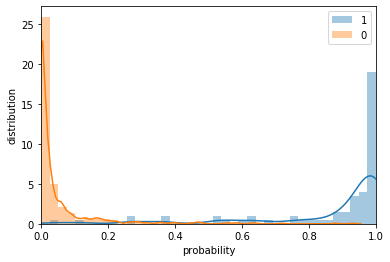

In [30]:
#import seaborn as sns
#import matplotlib.pyplot as plt

x = evaluate[evaluate['actual']==1].prob_1
y = evaluate[evaluate['actual']==0].prob_1

bins = np.linspace(0,1,40)

sns.distplot(x, bins=bins, label='1')
sns.distplot(y, bins=bins, label='0')
plt.xlim(0,1)
plt.xlabel('probability')
plt.ylabel('distribution')
plt.legend()
plt.plot()

### Classification report

In [31]:
from sklearn.metrics import classification_report

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Compute metrics
print(classification_report(y_test, y_pred))
#print("Accuracy: {}".format(cv.score(X_test, y_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       641
           1       0.89      0.92      0.91        78

    accuracy                           0.98       719
   macro avg       0.94      0.95      0.95       719
weighted avg       0.98      0.98      0.98       719



**interpretaion**
- Recall – What percent of the positive cases did you catch? 
- Precision – What percent of your predictions were correct?
- F1 score – What percent of positive predictions were correct? 
    - the harmonic mean between precision & recall
- The support is the number of occurence of the given class in your dataset

### confusion matrix

cm = pd.crosstab(
    evaluate["actual"]
    , evaluate["predictions"]
    , rownames = ["Actual"]
    , colnames = ["Prediction"]
    , margins = True
)
cm

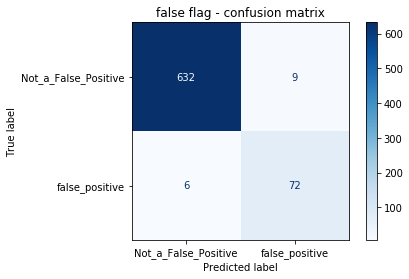

In [32]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test,y_test, cmap=plt.cm.Blues,display_labels=dict(Not_a_False_Positive=0,false_positive=1))
disp.ax_.set_title("false flag - confusion matrix")
plt.show()

### ROC curve

In [33]:
# Import necessary modules
from sklearn.metrics import auc, roc_curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(evaluate["actual"] , evaluate["predictions"])
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.9545181807272292


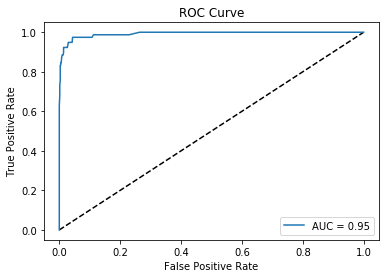

In [34]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## feature importance

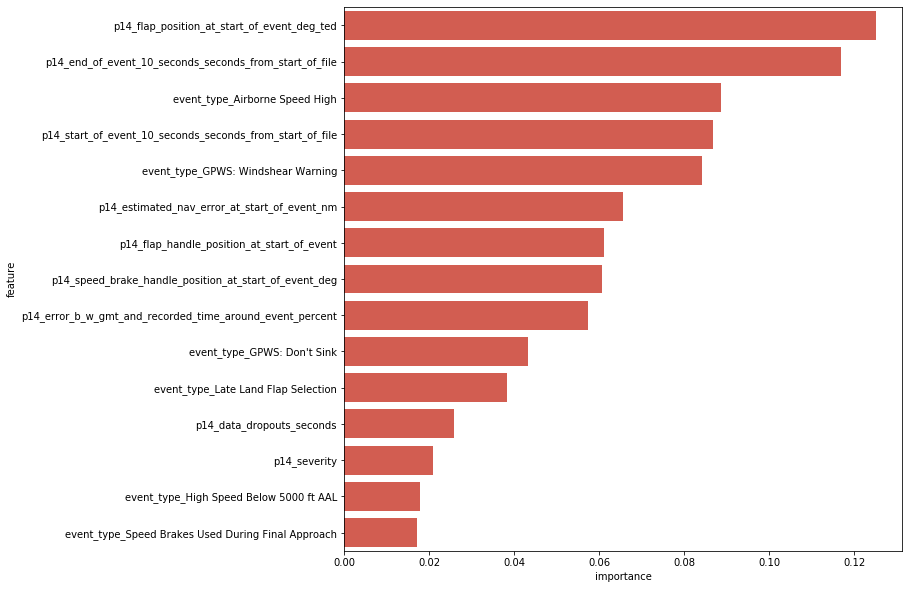

,feature,importance,cum_sum
0,p14_flap_position_at_start_of_event_deg_ted,0.125049,0.125049
1,p14_end_of_event_10_seconds_seconds_from_start...,0.116838,0.241887
2,event_type_Airborne Speed High,0.088577,0.330464
3,p14_start_of_event_10_seconds_seconds_from_sta...,0.086885,0.417349
4,event_type_GPWS: Windshear Warning,0.084284,0.501633
5,p14_estimated_nav_error_at_start_of_event_nm,0.065666,0.567299
6,p14_flap_handle_position_at_start_of_event,0.061271,0.628570
7,p14_speed_brake_handle_position_at_start_of_ev...,0.060802,0.689372
8,p14_error_b_w_gmt_and_recorded_time_around_eve...,0.057440,0.746811
9,event_type_GPWS: Don't Sink,0.043199,0.790010


Original number of columns: 59


In [35]:
n_records = 15

importances = pd.DataFrame({
    "feature": features,
    "importance": clf.feature_importances_
})
importances = importances.sort_values("importance", ascending=False).reset_index(drop=True)
importances["cum_sum"] = np.cumsum(importances.importance)

fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(importances[:n_records].importance, importances[:n_records].feature, color='#E74C3C')

plt.show()

display(importances[:n_records])
print(f"Original number of columns: {len(features)}")

## Create the explainer

In [36]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train
                                                   , feature_names= features
                                                   , class_names= target
                                                   , mode='regression'
                                                   , discretize_continuous=True
                                                   )

In [37]:
#np.random.seed(1)
#i = np.random.randint(0, X_test.shape[1])
exp = explainer.explain_instance(X_test[0], clf.predict_proba, num_features=7)
#exp.show_in_notebook(show_table=True, show_all=False)

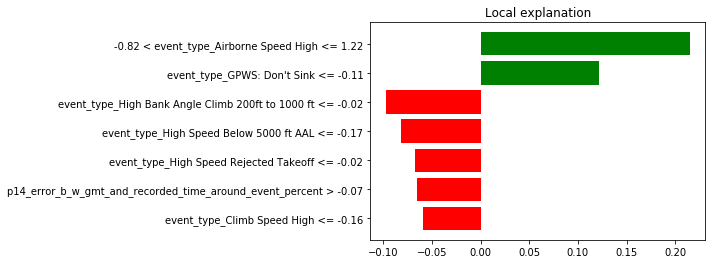

In [38]:
exp.as_pyplot_figure()
plt.show()

In [39]:
pd.DataFrame(exp.as_list(label=1), columns=['Feature', 'Value'])


,Feature,Value
0,-0.82 < event_type_Airborne Speed High <= 1.22,0.215096
1,event_type_GPWS: Don't Sink <= -0.11,0.121306
2,event_type_High Bank Angle Climb 200ft to 1000...,-0.097739
3,event_type_High Speed Below 5000 ft AAL <= -0.17,-0.081348
4,event_type_High Speed Rejected Takeoff <= -0.02,-0.067626
5,p14_error_b_w_gmt_and_recorded_time_around_eve...,-0.065294
6,event_type_Climb Speed High <= -0.16,-0.059532
